In [1]:
from modules.SignLanguageProcessor import load_and_preprocess_data,parse_frame
import os

In [2]:
ROOT_PATH = ''
sequences,labels,label_map = load_and_preprocess_data(os.path.join(ROOT_PATH,'data'))

In [3]:
num_classes = len(label_map)

In [4]:
len(labels)

1722

In [5]:
sequences.shape

(1722, 3, 61, 3)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    sequences, labels, test_size=0.4, stratify=labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [7]:
import numpy as np
def normalize_landmark_data(X):
    """
    Normalize the landmark features (x, y) to have zero mean and unit variance across the training set.
    Assumes X shape is (N, F, L, T), where F=3 (x, y, vis).
    """
    X = X.copy()
    # Flatten across all samples, landmarks, and frames
    x_vals = X[:, 0, :, :].flatten()
    y_vals = X[:, 1, :, :].flatten()

    # Compute mean and std
    x_mean, x_std = np.mean(x_vals), np.std(x_vals)
    y_mean, y_std = np.mean(y_vals), np.std(y_vals)

    # Normalize
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std

    return X, (x_mean, x_std), (y_mean, y_std)

def apply_normalization(X, x_mean, x_std, y_mean, y_std):
    X = X.copy()
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std
    return X


In [8]:
def reshape_frames_for_cnn(X, y):
    X = X.transpose(0, 3, 2, 1)  # (N, T, L, F)
    X = X[..., np.newaxis]       # (N, T, L, F, 1)
    return X,y

In [9]:

X_train_norm, (x_mean, x_std), (y_mean, y_std) = normalize_landmark_data(X_train)
X_val_norm  = apply_normalization(X_val, x_mean, x_std, y_mean, y_std)
X_test_norm = apply_normalization(X_test, x_mean, x_std, y_mean, y_std)

X_train_cnn, y_train_cnn = reshape_frames_for_cnn(X_train_norm, y_train)
X_val_cnn, y_val_cnn     = reshape_frames_for_cnn(X_val_norm, y_val)
X_test_cnn, y_test_cnn   = reshape_frames_for_cnn(X_test_norm, y_test)

print(X_train_cnn.shape)  
print(y_train_cnn.shape)


(1033, 3, 61, 3, 1)
(1033,)


In [10]:
input_shape = X_train_cnn.shape[1:]
print(input_shape)

(3, 61, 3, 1)


In [11]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_ds = train_ds.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_cnn, y_val_cnn))
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_cnn))
test_ds = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten,Input
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization

model = Sequential([
    Input((3, 61, 3, 1)),
    TimeDistributed(Conv2D(32, (3, 2), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2, 1))),
    TimeDistributed(Dropout(0.25)),

    TimeDistributed(Conv2D(64, (3, 2), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2, 1))),
    TimeDistributed(Flatten()),

    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_ds,validation_data=val_ds, epochs=50, batch_size=64)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.0948 - loss: 3.1329 - val_accuracy: 0.1192 - val_loss: 3.1134
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.2185 - loss: 2.6554 - val_accuracy: 0.0872 - val_loss: 3.0680
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3175 - loss: 2.3707 - val_accuracy: 0.1163 - val_loss: 3.0046
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3634 - loss: 2.2721 - val_accuracy: 0.1453 - val_loss: 2.9339
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4012 - loss: 2.0538 - val_accuracy: 0.2645 - val_loss: 2.7263
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4447 - loss: 1.9395 - val_accuracy: 0.2616 - val_loss: 2.5388
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4373 - loss: 1.9222 - val_accuracy: 0.3023 - val_loss: 2.4330
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5558 - loss: 1.7145 - val_accuracy: 0.4273 - v

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8481 - loss: 0.6277 
Test Accuracy: 0.8522
Test Loss: 0.6277


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

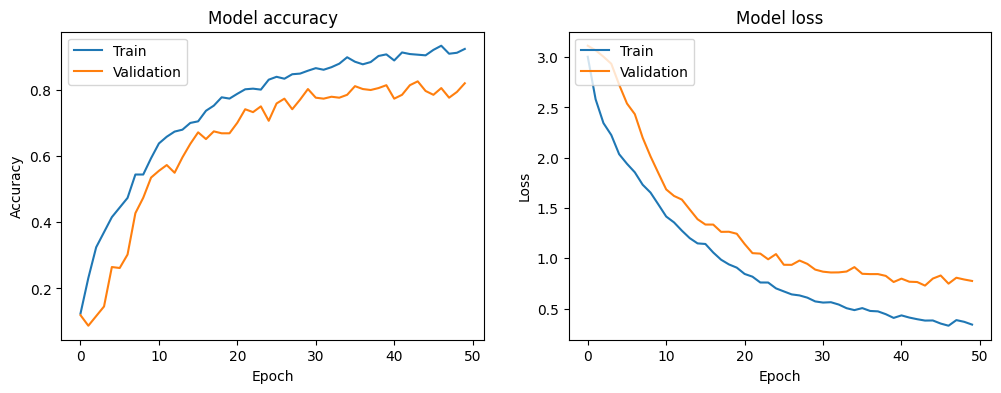

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

         baca      1.000     0.833     0.909        12
        bantu      1.000     0.727     0.842        11
        bapak      0.786     0.917     0.846        12
buangairkecil      1.000     1.000     1.000         6
         buat      0.812     1.000     0.897        13
         halo      0.900     1.000     0.947        18
          ibu      1.000     0.750     0.857         4
         kamu      0.682     0.789     0.732        19
         maaf      1.000     1.000     1.000        18
        makan      1.000     0.714     0.833        14
          mau      0.933     0.824     0.875        17
         nama      0.833     0.833     0.833        18
         pagi      0.947     0.900     0.923        20
        paham      0.950     0.950     0.950        20
        sakit      1.000     0.667     0.800         3
    sama-sama      0.885     0.920     0.902        25
         saya      0.600     0.500     0.545         6
      sel

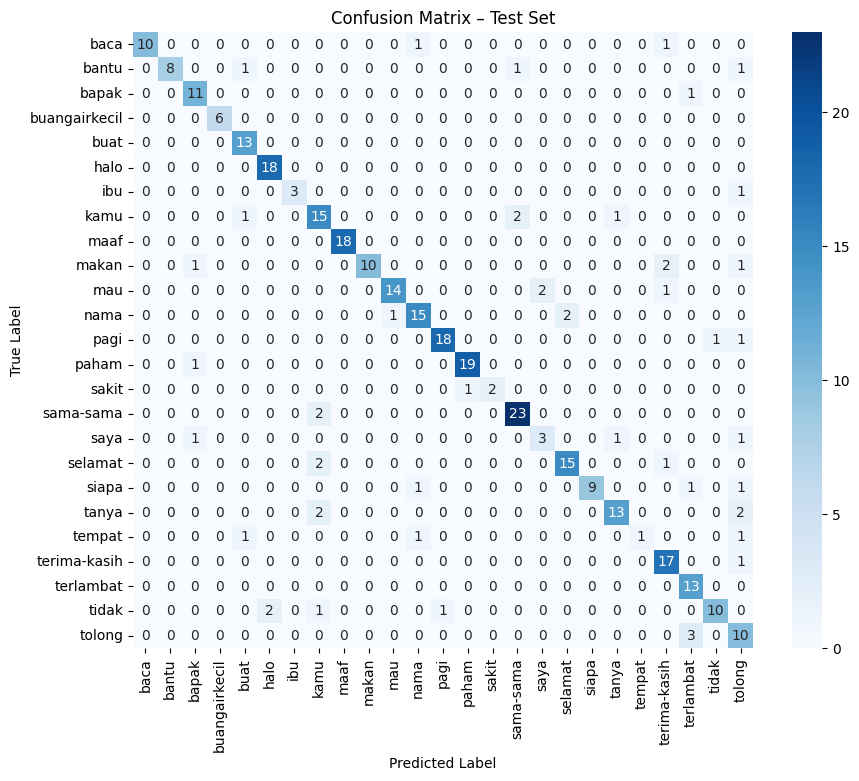

In [17]:
y_true, y_pred = [], []
target_names = [label_map[i] for i in range(len(label_map))]
for X_batch, y_batch in test_ds:
    y_true.append(y_batch.numpy())

    batch_pred = model.predict(X_batch, verbose=0)
    y_pred.append(np.argmax(batch_pred, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(
    y_true, y_pred,
    digits=3,                            
    target_names=target_names 
))

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
labels = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()